In [1]:
import sys
sys.path.append('../../code/hnn_beta')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, hnn_beta_param_function, UniformPrior,
                   get_dataset_psd, get_dataset_peaks, load_posterior, simulator_hnn)
from hnn_core import jones_2009_model
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
rng_seed = 123

sns.set()
sns.set_style("white")

device = 'cpu'
data_path = '../../data/hnn_beta'

with open(f'{data_path}/posteriors/hnn_beta_posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/hnn_beta_posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
zero_samples = posterior_metadata['zero_samples'] 

In [2]:
# Parameter bounds
for param_name, param_dict in prior_dict.items():
    print(f'{param_name}:{param_dict["bounds"]}', end=' ')

dist_var:(0, 10) prox_var:(0, 40) dist_exc:(-7, -5) prox_exc:(-7, -5) 

### Generate conditioning waveform

In [3]:
net = jones_2009_model()

simulator = partial(simulator_hnn, prior_dict=prior_dict, param_function=hnn_beta_param_function,
                    network_model=net)

In [7]:
# Values on [0,1] mapped to range of bounds defined in prior_dict
theta_cond_list = [np.array([0.25, 0.5, 0.99, 0.99]), np.array([0.75, 0.5, 0.75, 0.75])]

x_cond_list, theta_dict_list = list(), list()
for theta_cond in theta_cond_list:
    theta_dict = {param_name: param_dict['rescale_function'](theta_cond[idx], param_dict['bounds']) for 
                  idx, (param_name, param_dict) in enumerate(prior_dict.items())}

    x_cond = simulator(torch.tensor(theta_cond).float()).numpy()
    x_cond = x_cond[:,0,:]
    x_cond[:, :zero_samples] = np.repeat(x_cond[:, zero_samples], zero_samples).reshape(x_cond.shape[0], zero_samples)
                   
    theta_dict_list.append(theta_dict)
    x_cond_list.append(x_cond)


    print(theta_dict)

{'dist_var': 2.5, 'prox_var': 20.0, 'dist_exc': 9.54992627963112e-06, 'prox_exc': 9.54992627963112e-06}
joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Simulation time: 230.0 ms...
Simulation time: 240.0 ms...
Simulation time: 250.0 ms...
Simulation time: 260.0 ms...
Simulation time: 270.0 ms...
Simulat

/home/ntolley/Jones_Lab/hnn_sbi_examples/notebooks/hnn_beta/../../code/hnn_beta/utils.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32)


[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Simulation time: 230.0 ms...
Simulation time: 240.0 ms...
Simulation time: 250.0 ms...
Simulation time: 260.0 ms...
Simulation time: 270.0 ms...
Simulation time: 280.0 ms...
Simulation time: 290.0 ms...
Simulation time: 300.0 ms...
Simulation time: 310.0 ms...
Simulation time: 320.0 ms...
Simulation time: 330

Text(0, 0.5, 'Dipole (nAm)')

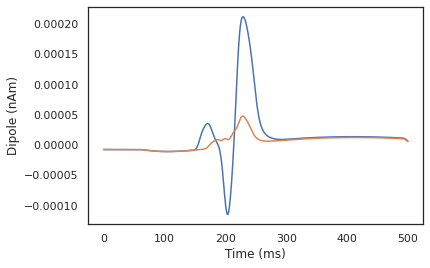

In [8]:
%matplotlib inline
t_vec = np.linspace(0, tstop, x_cond_list[0].shape[1])
plt.plot(t_vec, x_cond_list[0].squeeze())
plt.plot(t_vec, x_cond_list[1].squeeze())
plt.xlabel('Time (ms)')
plt.ylabel('Dipole (nAm)')

### Load trained posterior objects

In [6]:
prior = UniformPrior(parameters=list(prior_dict.keys()))
n_params = len(prior_dict)
limits = list(prior_dict.values())

# x_orig stores full waveform to be used for embedding
x_orig, theta_orig = np.load(f'{data_path}/sbi_sims/x_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
x_orig = x_orig[:,0,:]

posterior_names = list(posterior_state_dicts.keys())

# Pick posterior to load
name_idx = 0

input_type = posterior_names[name_idx]
posterior_dict = posterior_state_dicts[input_type]
state_dict = posterior_dict['posterior']
n_params = posterior_dict['n_params']
n_sims = posterior_dict['n_sims']
input_dict = posterior_dict['input_dict']

embedding_net =  input_dict['embedding_func'](**input_dict['embedding_dict'])

print(posterior_names)

['pca30']


In [20]:
print(f'Conditioning Feature: {posterior_names[name_idx]}')

num_samples = 1000
all_labels = list(prior_dict.keys())
all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

load_info = {name: {'x_train': posterior_dict['input_dict']['feature_func'](x_orig), 
                    'x_cond': posterior_dict['input_dict']['feature_func'](x_cond)}
             for name, posterior_dict in posterior_state_dicts.items()}


df_list, theta_cond_transformed_list = list(), list()
cond_name = ['Large', 'Small']
for x_cond, cond_name, theta_cond in zip(x_cond_list, cond_name, theta_cond_list):
    load_info = {name: {'x_train': posterior_dict['input_dict']['feature_func'](x_orig), 
                        'x_cond': posterior_dict['input_dict']['feature_func'](x_cond)}
                 for name, posterior_dict in posterior_state_dicts.items()}
    posterior = load_posterior(state_dict=state_dict,
                               x_infer=torch.tensor(load_info[input_type]['x_train'][:10,:]).float(),
                               theta_infer=torch.tensor(theta_orig[:10,:]), prior=prior, embedding_net=embedding_net)
    
    samples = posterior.sample((num_samples,), x=torch.tensor(load_info[input_type]['x_cond'].squeeze()))
    samples_transformed = linear_scale_array(samples.numpy(), all_bounds)

    theta_cond_transformed = linear_scale_array(theta_cond.reshape(1,-1), all_bounds)[0]
    df_dict = {name: samples_transformed[:, idx] for idx, name in enumerate(all_labels)}
    df_dict['cond_name'] = np.repeat(cond_name, num_samples)

    df_temp = pd.DataFrame(df_dict)
    
    theta_cond_transformed_list.append(theta_cond_transformed)
    df_list.append(df_temp)
df = pd.concat(df_list)

Conditioning Feature: pca30


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
df.columns = ['Distal Var (ms)', 'Proximal Var (ms)', 'Distal log(g)', 'Proximal log(g)', 'cond_name']

### Draw samples and plot

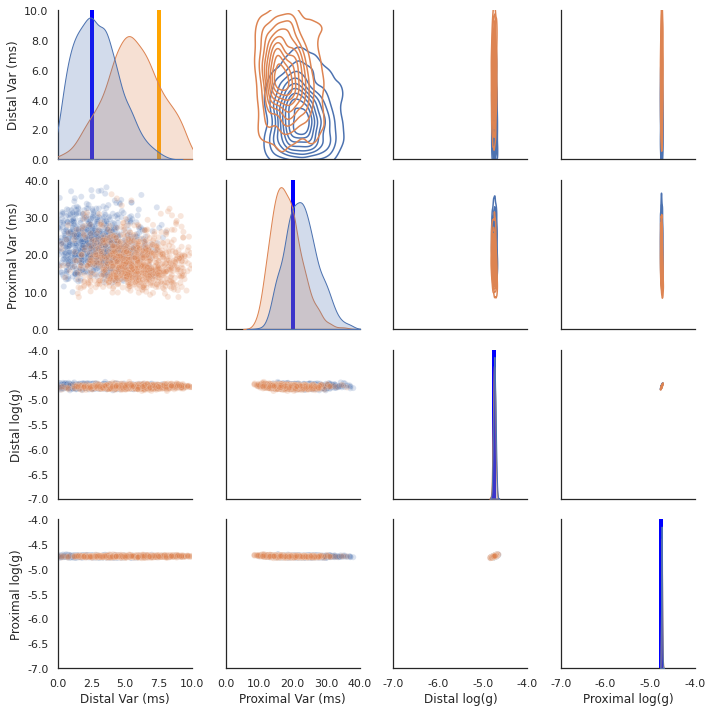

In [24]:
g = sns.PairGrid(df, hue='cond_name', diag_sharey=False)
g.map_lower(sns.scatterplot, alpha=0.2)
g.map_upper(sns.kdeplot, fill=False)
g.map_diag(sns.kdeplot, fill=True)

for idx in range(4):
    g.axes[idx, idx].axvline(theta_cond_transformed_list[1][idx], color='orange', linewidth=4) 
    g.axes[idx, idx].axvline(theta_cond_transformed_list[0][idx], color='blue', linewidth=4) 
    g.axes[idx, idx].set_xlim(all_bounds[idx])
    g.axes[idx, idx].set_ylim(all_bounds[idx])

for idx1 in range(4):
    for idx2 in range(4):
        g.axes[idx1, idx2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        g.axes[idx1, idx2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()